# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [209]:
# Core library
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import os

# Visualization library
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

---
## 2. Load data

In [210]:
# Find file path
path = os.getcwd()

In [211]:
df = pd.read_csv(os.path.join(path, 'merged_data_after_eda.csv'), index_col=0)
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [212]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price6m_p1_var,price6m_p2_var,price6m_p3_var,price6m_p1_fix,price6m_p2_fix,price6m_p3_fix,price6m_p1,price6m_p2,price6m_p3,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [213]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [214]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [215]:
df = pd.merge(df, diff, on="id")
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price6m_p3_var,price6m_p1_fix,price6m_p2_fix,price6m_p3_fix,price6m_p1,price6m_p2,price6m_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14606 entries, 0 to 14605
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               14606 non-null  object        
 1   channel_sales                    14606 non-null  object        
 2   cons_12m                         14606 non-null  int64         
 3   cons_gas_12m                     14606 non-null  int64         
 4   cons_last_month                  14606 non-null  int64         
 5   date_activ                       14606 non-null  datetime64[ns]
 6   date_end                         14606 non-null  datetime64[ns]
 7   date_modif_prod                  14606 non-null  datetime64[ns]
 8   date_renewal                     14606 non-null  datetime64[ns]
 9   forecast_cons_12m                14606 non-null  float64       
 10  forecast_cons_year               14606 non-null  int64    

### Time as customer

We will create feature to see time as customer by year

In [217]:
df["time_customer"] = ((df["date_end"] - df["date_activ"]) / np.timedelta64(1, "Y")).astype(int)
time_customer = df[['time_customer', 'churn', 'id']].groupby(['time_customer', 'churn'])['id'].count().unstack(level=1)
time_percentage = (time_customer.div(time_customer.sum(axis=1), axis=0) * 100)

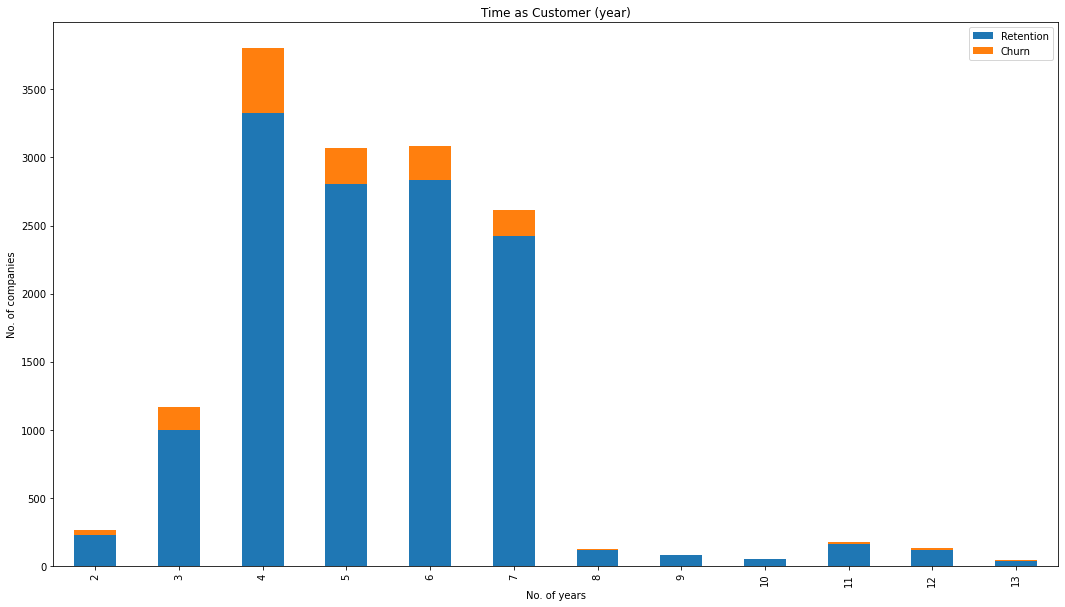

In [218]:
time_customer.plot(kind="bar", figsize=(18,10), stacked=True, title="Time as Customer (year)")
plt.legend(["Retention", "Churn"], loc="upper right")
plt.ylabel("No. of companies")
plt.xlabel("No. of years")
plt.show()

As our original time is in datetime format we will convert them to numerical relative to reference date (1 Jan 2016)

In [219]:
## Create function to return months compare to reference
def convert_months(ref_date, df, column):
    """
    Input a time column to return months
    """
    d = ref_date - df[column]
    months = (d / np.timedelta64(1, 'M')).astype(int)
    return months

In [220]:
# We will use 1 Jan 2016 as ref
ref_date = datetime(2016, 1, 1)

# Convert datetime columns
df['months_activ'] = convert_months(ref_date, df, 'date_activ')
df['months_end'] = convert_months(ref_date, df, 'date_end')
df['months_modif'] = convert_months(ref_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(ref_date, df, 'date_renewal')

In [221]:
# Drop original datetime columns
remove = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,price6m_p2,price6m_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,time_customer,months_activ,months_end,months_modif,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,9.953056e+01,4.423670e+01,1,0.020057,3.700961,3,30,-5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,7,76,-7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,6,68,-3,68,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,6,69,-2,69,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,6,71,-2,71,9


### Transform boolean data

We will use onehot encoding to transform `has_gas` from t to 1 and f to 0

In [222]:
df['has_gas']=df['has_gas'].replace(["t", "f"],[1,0])

### Transform category data

A model cannot accept category data so we need to transform them into numerical.

We can use label encoding but it introduces the concept of an order into feature which may not inherently present 0 < 1 < 2 < 3 ...

Another way to encode is to use onhot encoding or dummy variables which will fill columns as 1 or 0 in each columns similar to boolean

**channel_sales**

In [223]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

There are variable that there are some variable that have very low values.
Compare to over 14,000 rows of our data set. The last 3 categories can be dropped as they will not added much to predictive power.

In [224]:
df=pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,time_customer,months_activ,months_end,months_modif,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,3,30,-5,2,6,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,7,76,-7,76,4,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,6,68,-3,68,8,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,6,69,-2,69,9,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,6,71,-2,71,9,1,0,0,0,0


**origin_up**

In [225]:
# Transform origin_up
df['origin_up'] = df['origin_up'].astype('category')
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

Same as channel_sales the last 3 categories have very low frequency so we will drop them

In [226]:
df=pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,71,9,1,0,0,0,0,1,0,0


### Log transformation

As there are skewness which most predictive model need normally distributed varaibles. Log is usually recommend to use

In [227]:
# Apply log 10 transform
to_transform = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'has_gas', 'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
                    'forecast_price_energy_peak', 'forecast_price_pow_off_peak']
for i in to_transform:
    #print("'"+ i +"'")
    df["'"+ i +"'"] = np.log10(df[i]+1)

df[to_transform].describe()

,cons_12m,cons_gas_12m,cons_last_month,imp_cons,has_gas,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,152.786896,0.181501,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,341.369366,0.385446,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,0.000000,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,37.395000,0.000000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,193.980000,0.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,15042.790000,1.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


C:\Users\Administrator\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Administrator\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Administrator\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

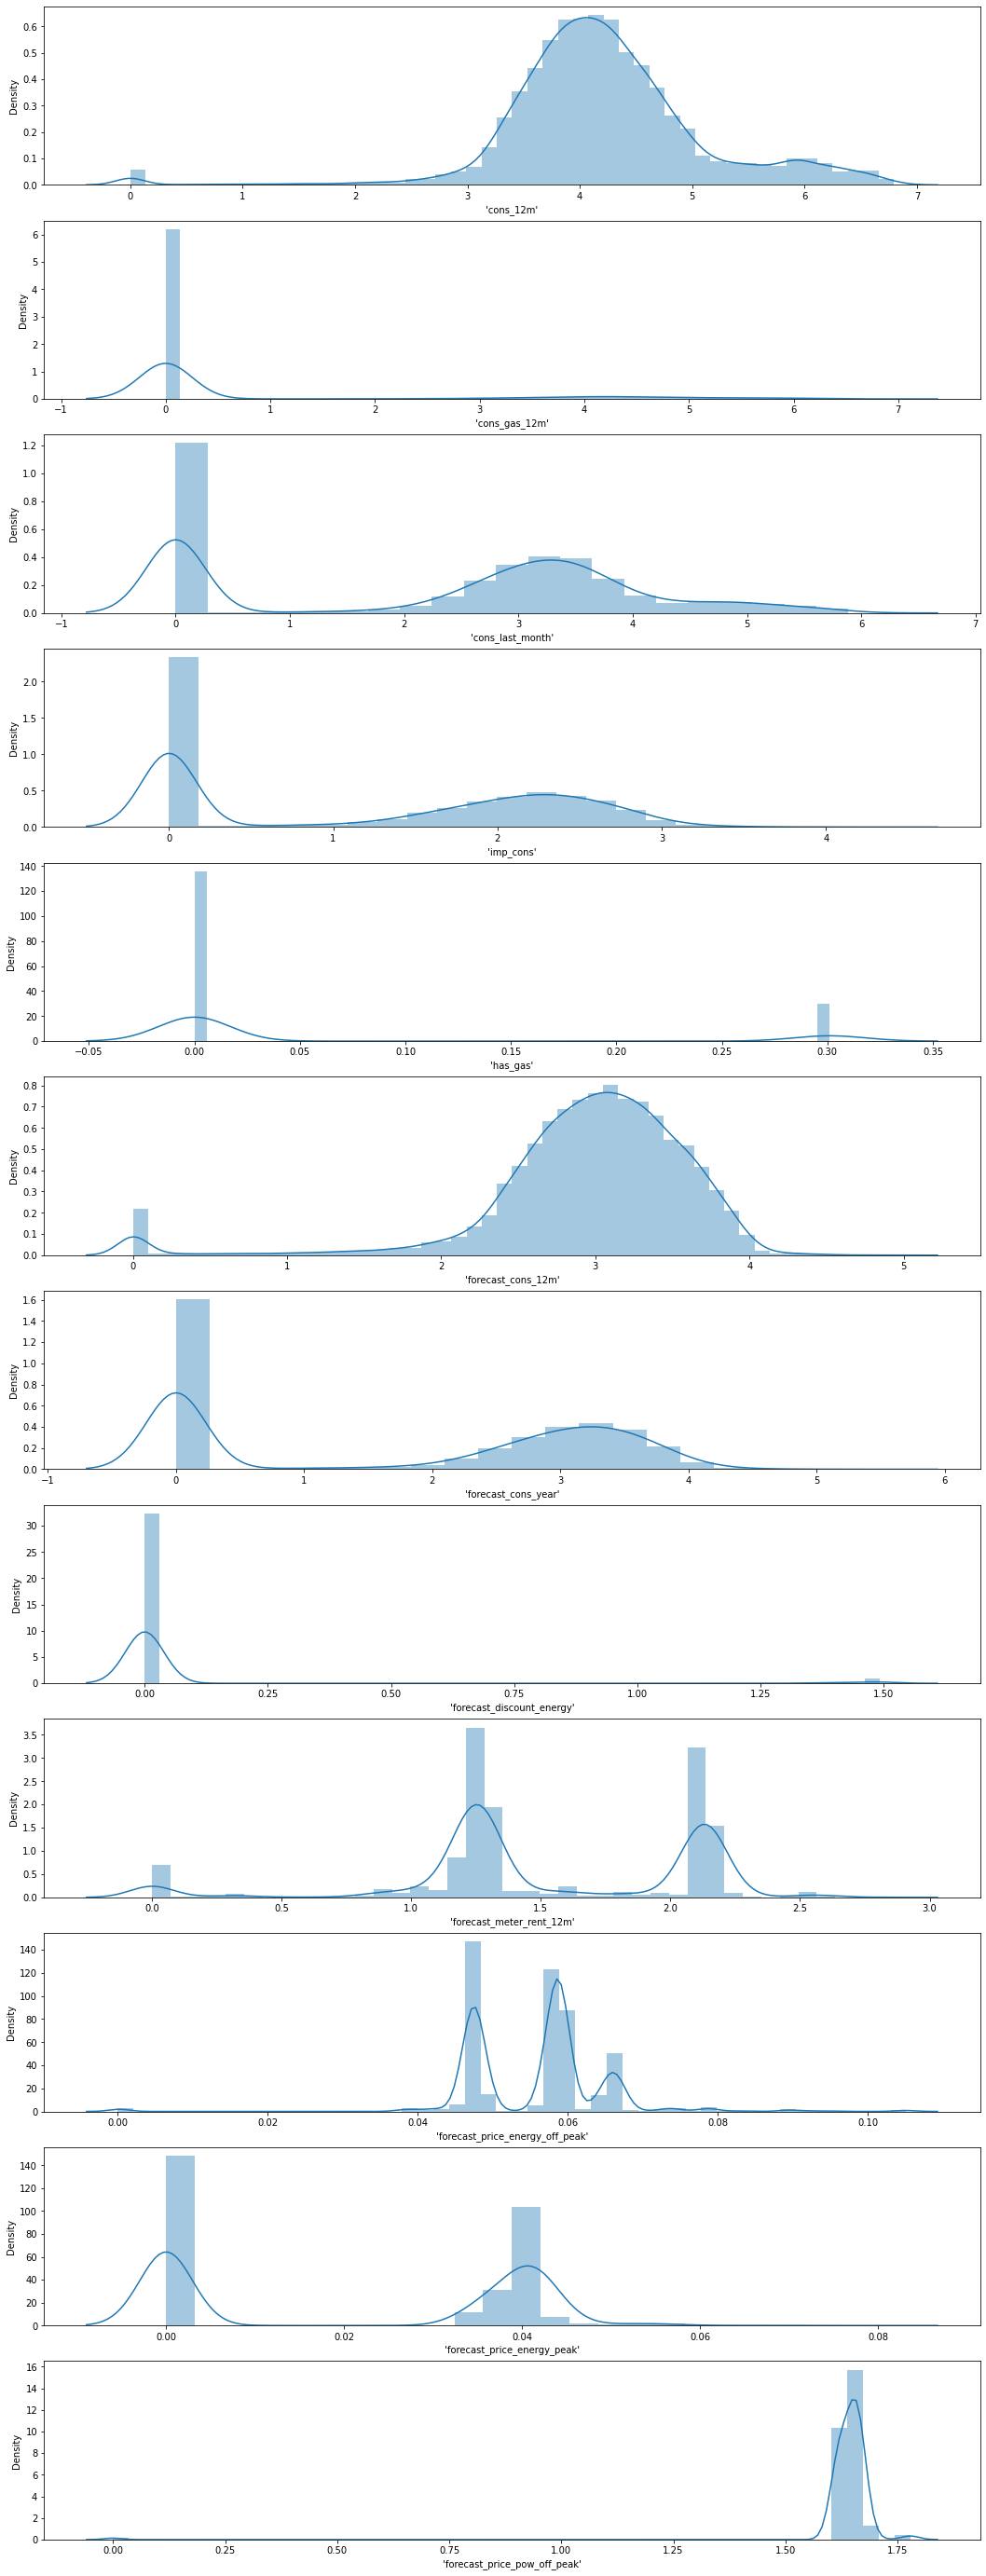

In [228]:
# Plot to view data
fig, axs = plt.subplots(nrows=len(to_transform), figsize=(18,50))
for i in to_transform:
    #print(to_transform.index(i))
    sns.distplot((df["'"+ i +"'"].dropna()), ax=axs[to_transform.index(i)])
plt.show()

### Correlation

In [229]:
correlation = df.corr()

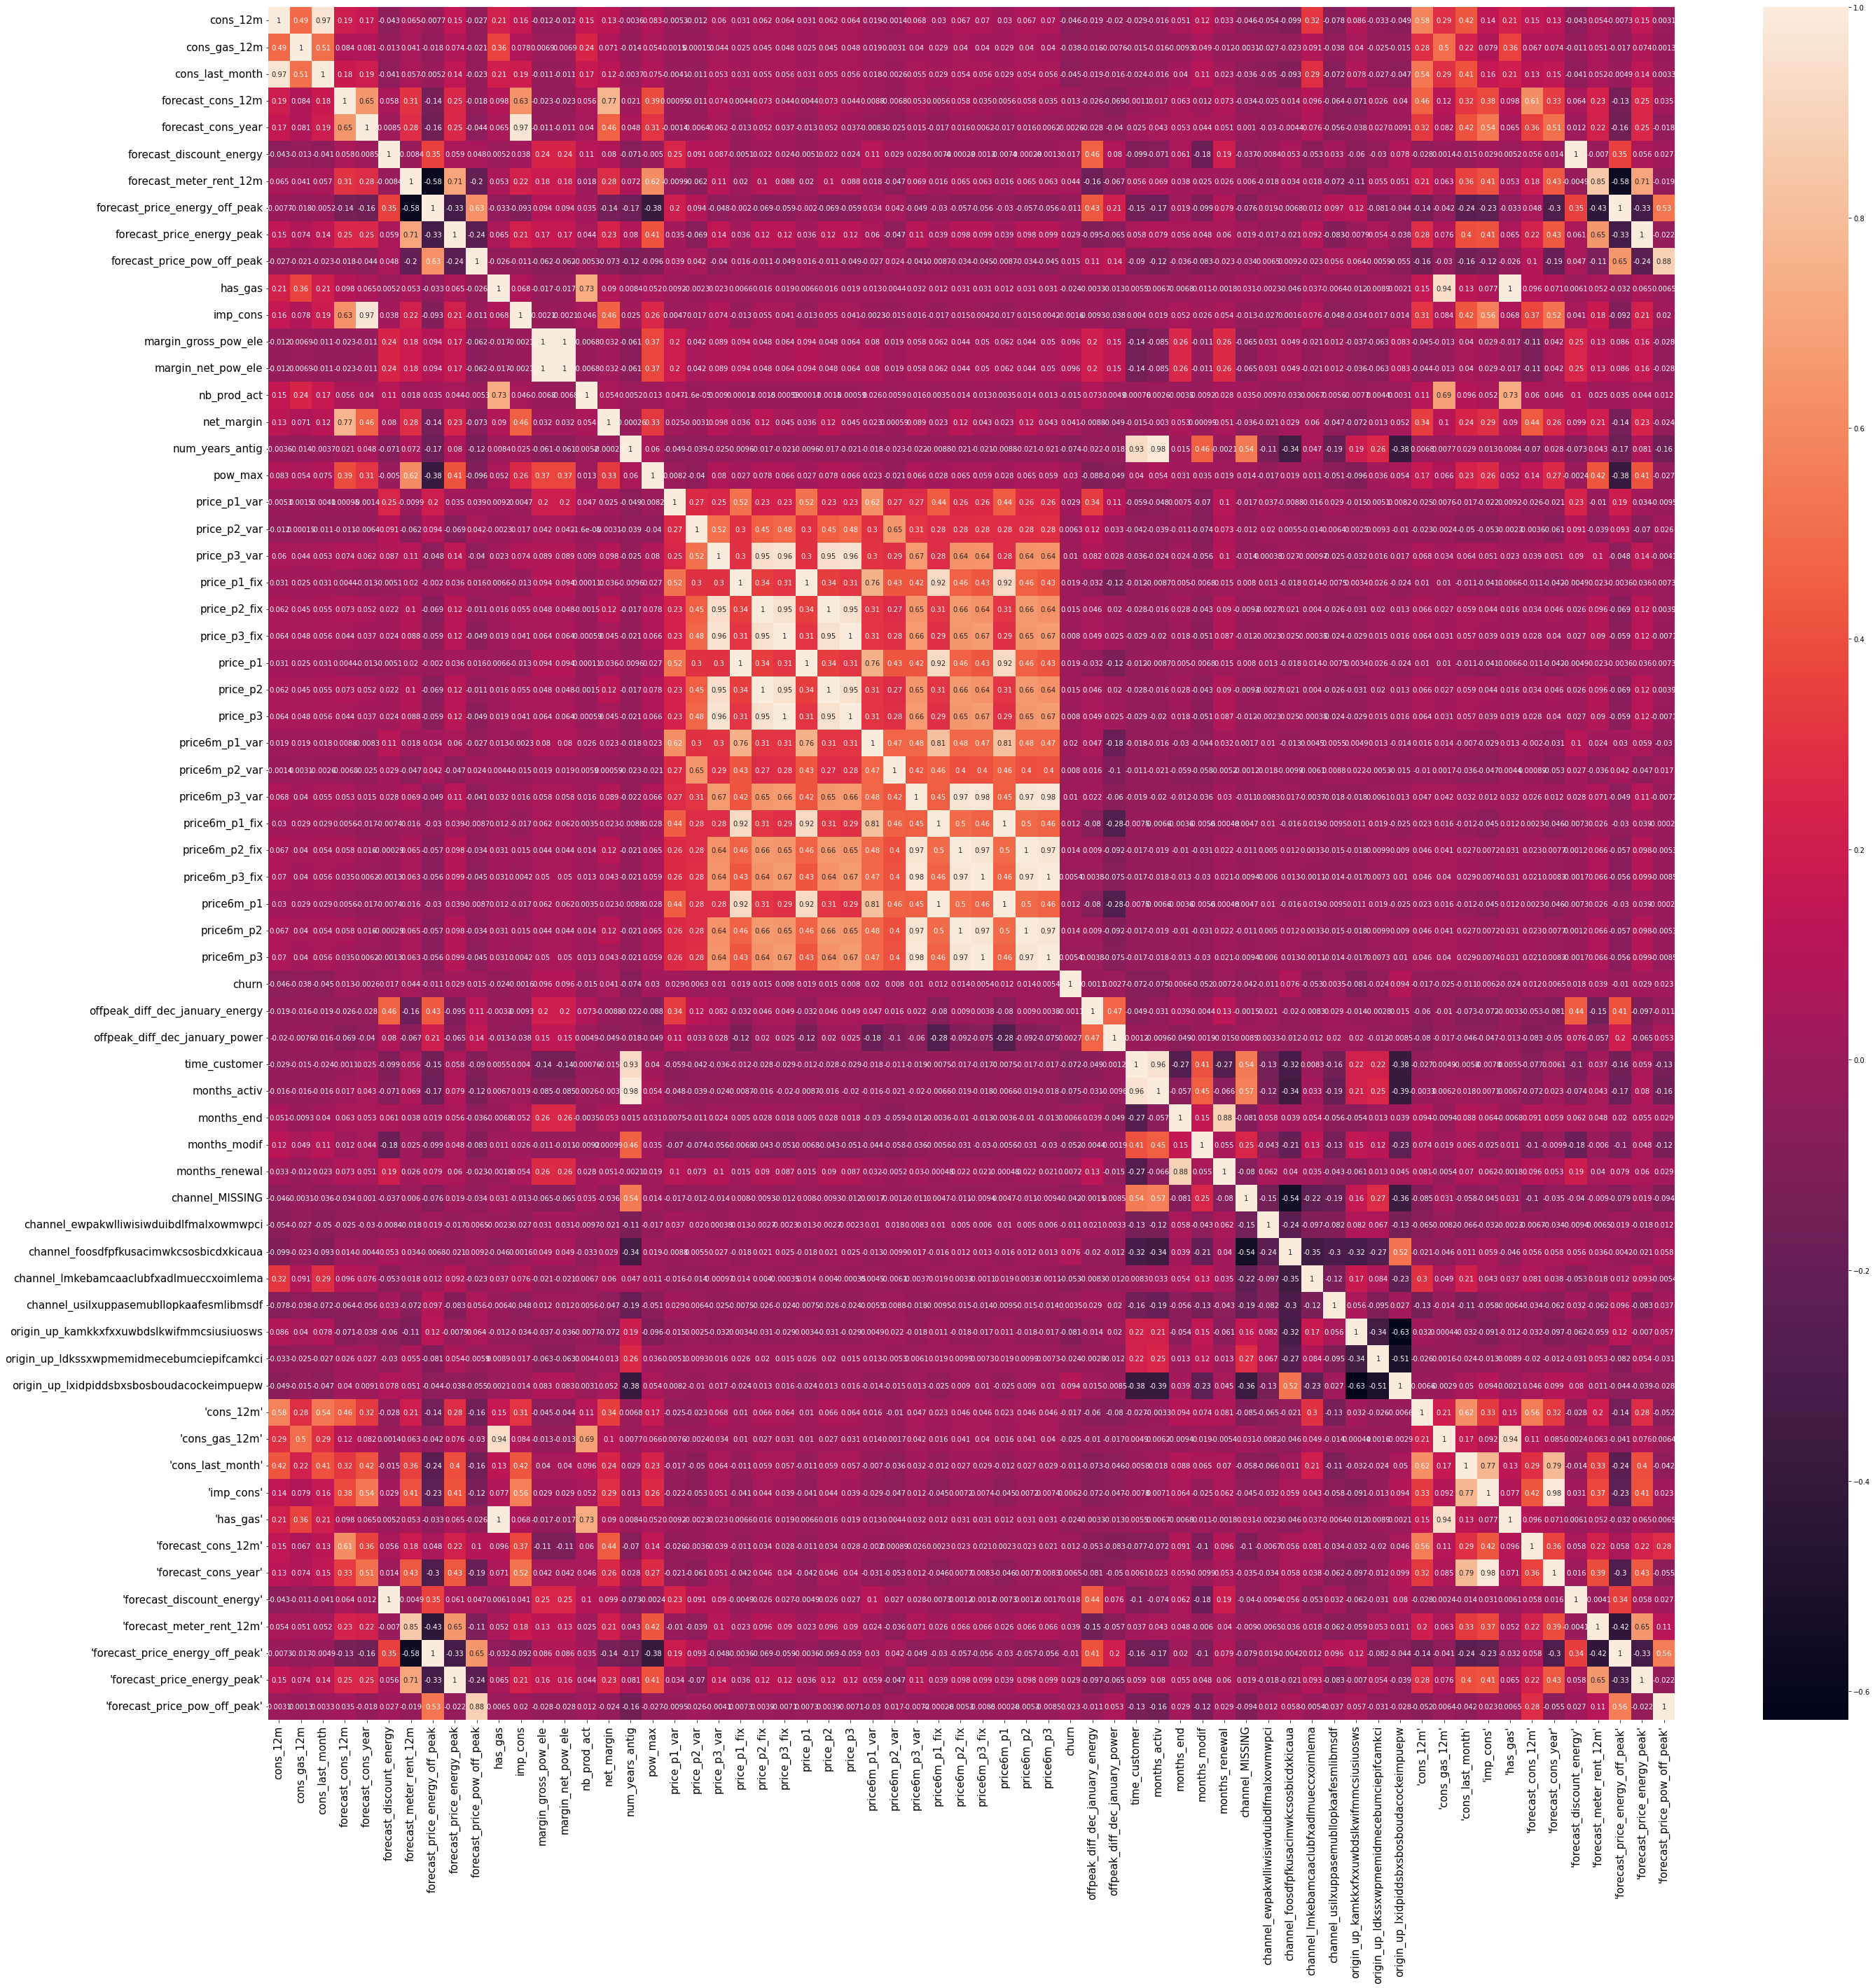

In [230]:
# Plot correlation
plt.figure(figsize=(45,45))
sns.heatmap(correlation, xticklabels=correlation.columns.values, yticklabels=correlation.columns.values, annot=True)

#Adjust font size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

There are several value which have a very high correlation with each other. So consider dropping them

In [231]:
columnsdrop = ['cons_12m', 'forecast_cons_year', 'has_gas', 'imp_cons', 'num_years_antig']
df = df.drop(columns=columnsdrop)
df.head()

,id,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,margin_gross_pow_ele,...,'cons_last_month','imp_cons','has_gas','forecast_cons_12m','forecast_cons_year','forecast_discount_energy','forecast_meter_rent_12m','forecast_price_energy_off_peak','forecast_price_energy_peak','forecast_price_pow_off_peak'
0,24011ae4ebbe3035111d65fa7c15bc57,54946,0,0.00,0.0,1.78,0.114481,0.098142,40.606701,25.44,...,0.000000,0.00000,0.30103,0.000000,0.000000,0.0,0.444045,0.047073,0.040659,1.619163
1,d29c2c54acc38ff3c0614d0a653813dd,0,0,189.95,0.0,16.27,0.145711,0.000000,44.311378,16.38,...,0.000000,0.00000,0.00000,2.280920,0.000000,0.0,1.237292,0.059075,0.000000,1.656207
2,764c75f661154dac3a6c254cd082ea7d,0,0,47.96,0.0,38.72,0.165794,0.087899,44.311378,28.60,...,0.000000,0.00000,0.00000,1.689841,0.000000,0.0,1.599009,0.066622,0.036589,1.656207
3,bba03439a292a1e166f80264c16191cb,0,0,240.04,0.0,19.83,0.146694,0.000000,44.311378,30.22,...,0.000000,0.00000,0.00000,2.382089,0.000000,0.0,1.318689,0.059448,0.000000,1.656207
4,149d57cf92fc41cf94415803a877cb4b,0,526,445.75,0.0,131.73,0.116900,0.100015,40.606701,44.91,...,2.721811,1.72689,0.00000,2.650065,2.721811,0.0,2.122969,0.048014,0.041399,1.619163


---
## 4.Modeling

Now that we have data with features we engineered. We can start training a predictive model. There are many model that we can use but in this case we will use `Random Forest` as requested.

In [232]:
## Import ML model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Data Sampling

We need to split data into training and test samples. This will help us see how well model will do with new data.

Usually a typical % for testing is between 20-30%, we will use 75-25% between train and test.

In [233]:
# Make copy of data
train_df = df.copy()

# Seperate target variables (Churn) from independent variables
y=df['churn']
X=df.drop(columns=['id', 'churn'])
print(y.shape)
print(X.shape)

(14606,)
(14606, 58)


In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 58)
(10954,)
(3652, 58)
(3652,)


### Model Training

A `Random Forest` is in the category of `ensemble` algorithms as the `Forest` refers to a collection of `Decision Trees` that we can control how large the forest is.

The `ensemble` algorithm is poweful because the laws of averaging. With `ensemble` methods, we can train 1000's of decision tree instead of 1 model.
They will using different splits of data and different patterns.

Addition advantages include:
* Random Forest model uses a rule-based approach instead of distance calculation so features no need to be scaled.
* Able to handle non-linear parameters better than linear based models

Disadvantages:
* Need large computation power to train with a large dataset.
* Long training time due to increased complexity and size of three ensemble

In [235]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

### Evaluation

We will use 3 metrics to evaluate performace:
* Accuracy = The ratio of correctly predicted observations to the total observations
* Precision = The ability of the classifier to not label a negative sample as positive
* Recall = The ability of the classifier to find all the positive samples.

In [236]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [237]:
y_test.value_counts()

0    3286
1     366
Name: churn, dtype: int64

In [238]:
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test,predictions)}")
print(f"Precision: {metrics.precision_score(y_test,predictions)}")
print(f"Recall: {metrics.recall_score(y_test,predictions)}")

True Positives: 16
False Positives: 3
True Negatives: 3283
False Negatives: 350

Accuracy: 0.9033406352683461
Precision: 0.8421052631578947
Recall: 0.04371584699453552


There are few thins to point out:
* The test set about 10% of the rows are churn ( churn = 1)
* At true negative we have 3284 out of 3286 this mean that out of negative case (churn=0). We predicted 3284 as negative which is very good.
* At false negative we predicted client to not churn (churn = 0) when in fact they churned (churn = 1). We get quite high at 351 as we want false negative to be close as 0. We need to address this to improving the model.
* At false positive we predicted client to churn (churn = 1) when in fact they have not (churn = 0). We get the value of 2 in this case which is good.
* At true positive we have total of 366 churned clients but we are only able to predict 15 out of 366 which is very poor.
* At the accuracy score is misleading so we need to use precision and recall too. It may be high but did not tell us full story.
* At the prediction score show 0.88 which is not bad but can be improved.
* At the recall show that the classifier has a very poor ability to indentify positive samples. We need to improve this

### Model Understanding

We will look at feature improtances. There are several ways to calculate them but with `Random Forest` we can use the built-in method on the trained model.
In `Random Forest` the feature improtance represents the number of times each feature is used for plitting across all trees.

In [239]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_}).sort_values(by='importance', ascending=True).reset_index()

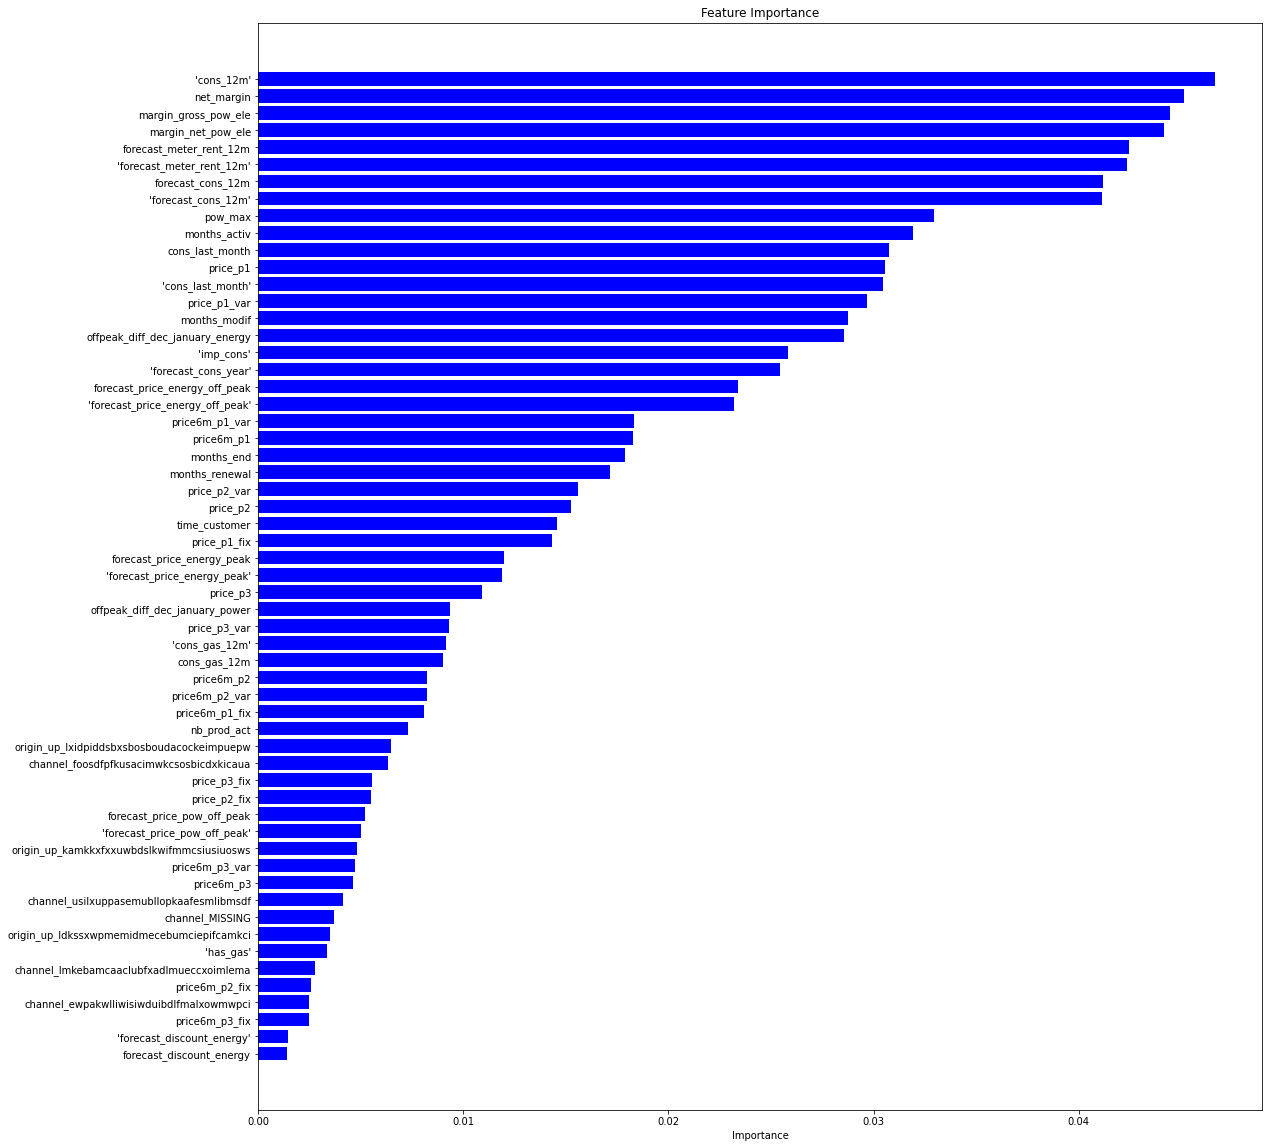

In [240]:
plt.figure(figsize=(18,20))
plt.title("Feature Importance")
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='b', align='center')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel("Importance")
plt.show()

From the chart:
* Consumption over 12 months is a top driver
* Times seems to be an influential factor
* Our colleage feature is in the top half


In [241]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [242]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [243]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')